**Trabajo realizado por Alberto Garzón - Análisis del dato - TFG**

Realizado en Google Colab. Para su pleno funcionamiento y evitar descargas, se va a necesitar subir los siguientes datasets, en Google Colab:


*   'CSV Twitter20kV5.csv'
*   'clusters_asignados.csv'
*   'clusters_kmeans'
*   'Dataset_Completo_Integrado'
*   'Excel Instagram'
*   'Excel Tiktok 1k'
*   'CSV Instagram 10kVF'
*   'CSV TikTok 1kVF'


**Planteamiento 1, para X: PCA, K-Means, Sentiment Analysis, Regresión Lineal Múltiple, Random Forest Regressor & Métricas de validación de la clusterización.**

In [ ]:
#Instalar lo necesario, en caso de querer RUN:
!pip install --quiet seaborn scikit-learn pandas matplotlib
!pip install emoji

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import RobustScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from google.colab import files

df_twitter = pd.read_csv('CSV Twitter20kV5.csv', delimiter=';', encoding='ISO-8859-1', on_bad_lines='skip')

#Información del dataset, para comprobar que funciona correctamente. Se observan las 20.000 Obs y las 66 Variables.
print("Dimensiones del dataset:", df_twitter.shape)
df_twitter.head()

Dimensiones del dataset: (20000, 66)


<ipython-input-2-12de9016a4f3>:10: DtypeWarning: Columns (47) have mixed types. Specify dtype option on import or set low_memory=False.
  df_twitter = pd.read_csv('CSV Twitter20kV5.csv', delimiter=';', encoding='ISO-8859-1', on_bad_lines='skip')


,author/canDm,author/canMediaTag,author/coverPicture,author/createdAt,author/description,author/entities/url/urls/0/display_url,author/entities/url/urls/0/url,author/favouritesCount,author/followers,author/following,...,quote/text,quote/viewCount,quoteCount,quoteId,replyCount,retweetCount,source,text,twitterUrl,viewCount
0,VERDADERO,VERDADERO,https://pbs.twimg.com/profile_banners/12384606...,Fri Mar 13 13:43:25 +0000 2020,??? +470K YT ?? AUTOR TUITS: Joan Miquel MJ ??...,bit.ly/LaReunionSecre,https://t.co/AIUiVxMuBT,17660,156224,6,...,NaN,NaN,0,NaN,21,23,Twitter for iPhone,Sánchez ???? propone acabar con el anonimato e...,https://twitter.com/LRsecreta/status/188216365...,28770.0
1,FALSO,FALSO,https://pbs.twimg.com/profile_banners/11696643...,Thu Sep 05 17:32:23 +0000 2019,?? | Noticias. Te contamos lo que ningún otro ...,derechadiario.com.ar,https://t.co/N2c72UwTYl,2297,458451,211,...,NaN,NaN,3,NaN,12,39,Twitter for Android,???????? | Enfermo de poder: El autoritario pr...,https://twitter.com/laderechadiario/status/188...,53980.0
2,FALSO,VERDADERO,https://pbs.twimg.com/profile_banners/10906475...,Wed Jan 30 16:26:47 +0000 2019,Mi objetivo es hacer camino para todos. Es un ...,nataliachueca.es,https://t.co/ZZF3thxzhl,9683,4623,365,...,NaN,NaN,1,NaN,7,9,Twitter for iPhone,? Desinformación desde el Gobierno de Sánchez....,https://twitter.com/ChuecaNatalia/status/18821...,14930.0
3,VERDADERO,FALSO,https://pbs.twimg.com/profile_banners/15669578...,Thu Jun 17 17:03:03 +0000 2010,Soy 4T hasta la médula. Apoyo al Sr. President...,NaN,NaN,108019,48005,43955,...,NaN,NaN,1,NaN,14,60,Twitter Web App,@AristeguiOnline ¿Qué clase de nota es esa?\nN...,https://twitter.com/AngMariscal4T/status/18821...,8170.0
4,FALSO,VERDADERO,https://pbs.twimg.com/profile_banners/16466012...,Thu Apr 13 19:48:54 +0000 2023,El contexto. Creador de @EstoyAvisando. Recono...,NaN,NaN,12857,17227,260,...,?? ÚLTIMA HORA | Pedro Sánchez propondrá a la ...,9347100.0,0,"1,88208E+33",11,27,Twitter for Android,"El anonimato en las redes no es el problema, y...",https://twitter.com/SoyContext/status/18821230...,21300.0


In [ ]:
#Cogemos solo las columnas que vamos a utilizar, de interés
columns_of_interest = [
    "likeCount", "retweetCount", "replyCount", "quoteCount", "viewCount",
    "author/followers", "author/following", "author/isBlueVerified", "lang", "fullText"
]

df_twitter_exploratory = df_twitter[columns_of_interest].copy()

#Rellenamos los valores nulos en 'viewCount' con la mediana
df_twitter_exploratory["viewCount"].fillna(df_twitter_exploratory["viewCount"].median(), inplace=True)

#Aqui convertimos la variable 'isBlueVerified' a valores numéricos (0 = No, 1 = Sí)
df_twitter_exploratory["author/isBlueVerified"] = df_twitter_exploratory["author/isBlueVerified"].map({"True": 1, "False": 0})

#Seleccionamos las variables para tener en cuenta en el clustering
cluster_features = ["likeCount", "retweetCount", "replyCount", "viewCount", "author/followers"]
df_cluster = df_twitter_exploratory[cluster_features].fillna(0)

#Transformamos datos con logaritmo para mejorar distribución. Por ejemplo, los followers son datos altos por lo que así es más fácil de entender.
df_cluster_log = df_cluster.copy()
df_cluster_log += 1
df_cluster_log = np.log(df_cluster_log)

df_cluster_sample = df_cluster_log

print("Datos preparados para la clusterización:", df_cluster_sample.shape)


Datos preparados para la clusterización: (20000, 5)


<ipython-input-3-41823f4d85e5>:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_twitter_exploratory["viewCount"].fillna(df_twitter_exploratory["viewCount"].median(), inplace=True)


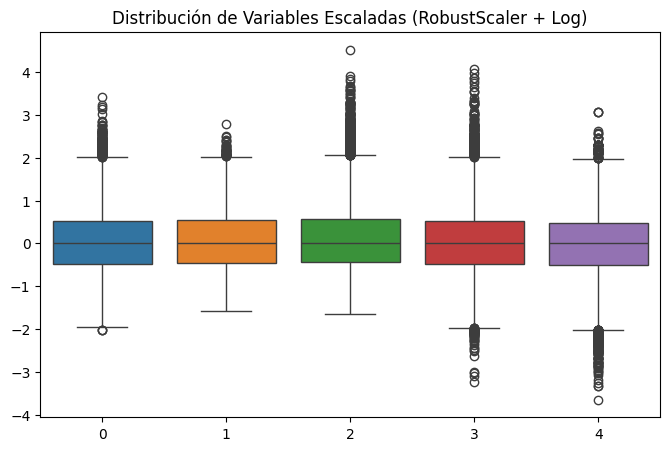

In [ ]:
from sklearn.preprocessing import RobustScaler

#Escalamos los datos con RobustScaler
scaler = RobustScaler()
df_cluster_scaled = scaler.fit_transform(df_cluster_sample)

#Visualización
plt.figure(figsize=(8,5))
sns.boxplot(data=df_cluster_scaled)
plt.title("Distribución de Variables Escaladas (RobustScaler + Log)")
plt.show()

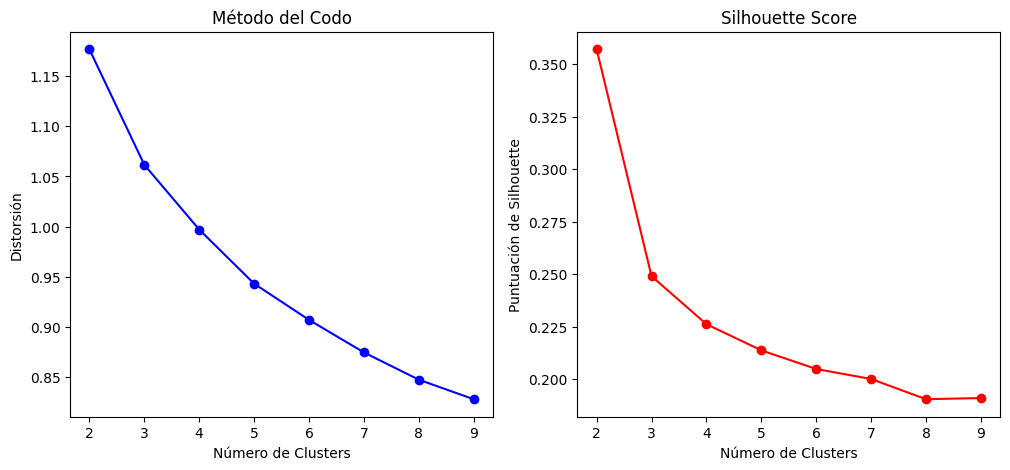

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import RobustScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from google.colab import files
from scipy.spatial.distance import cdist
from sklearn.metrics import silhouette_score

distortions = []
silhouette_scores = []
K_range = range(2, 10)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(df_cluster_scaled)
    distortions.append(sum(np.min(cdist(df_cluster_scaled, kmeans.cluster_centers_, 'euclidean'), axis=1)) / df_cluster_scaled.shape[0])
    silhouette_scores.append(silhouette_score(df_cluster_scaled, kmeans.labels_))

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(K_range, distortions, 'bo-')
plt.xlabel("Número de Clusters")
plt.ylabel("Distorsión")
plt.title("Método del Codo")

plt.subplot(1,2,2)
plt.plot(K_range, silhouette_scores, 'ro-')
plt.xlabel("Número de Clusters")
plt.ylabel("Puntuación de Silhouette")
plt.title("Silhouette Score")

plt.show()

In [ ]:
from sklearn.cluster import KMeans

# Aplicar K-Means con el número óptimo de clusters
optimal_k = 4
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10, init="k-means++")

# Asignar clusters a los tweets
df_twitter_exploratory["cluster_kmeans"] = kmeans.fit_predict(df_cluster_scaled)

# Guardar la asignación de clusters en un CSV para análisis posterior
df_twitter_exploratory[["fullText", "cluster_kmeans"]].to_csv("clusters_asignados.csv", index=False)

print("Archivo clusters_asignados.csv generado y listo para análisis de texto.")

Archivo clusters_asignados.csv generado y listo para análisis de texto.


<ipython-input-8-b040a9addf09>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df_twitter_exploratory["cluster_kmeans"], palette="Set2")


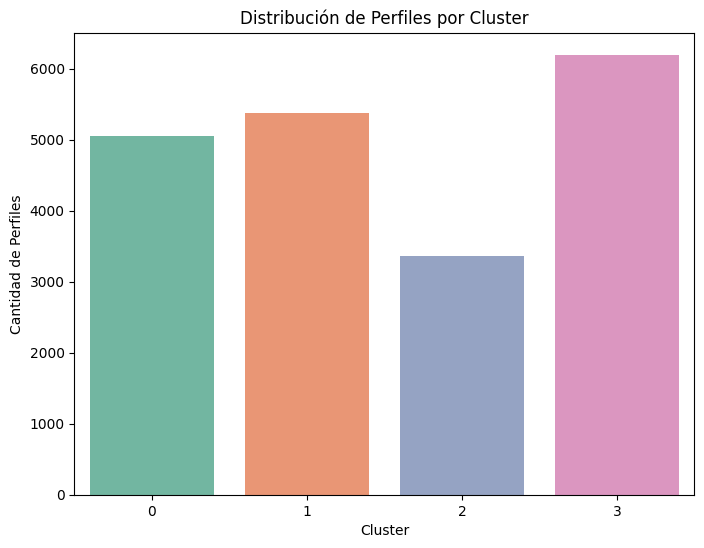

In [ ]:
from sklearn.cluster import KMeans

#Número ótpimo, obtenido en la celda anterior
optimal_k = 4
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10, init="k-means++")
df_twitter_exploratory["cluster_kmeans"] = kmeans.fit_predict(df_cluster_scaled)

#Visualización
plt.figure(figsize=(8, 6))
sns.countplot(x=df_twitter_exploratory["cluster_kmeans"], palette="Set2")
plt.xlabel("Cluster")
plt.ylabel("Cantidad de Perfiles")
plt.title("Distribución de Perfiles por Cluster")
plt.show()

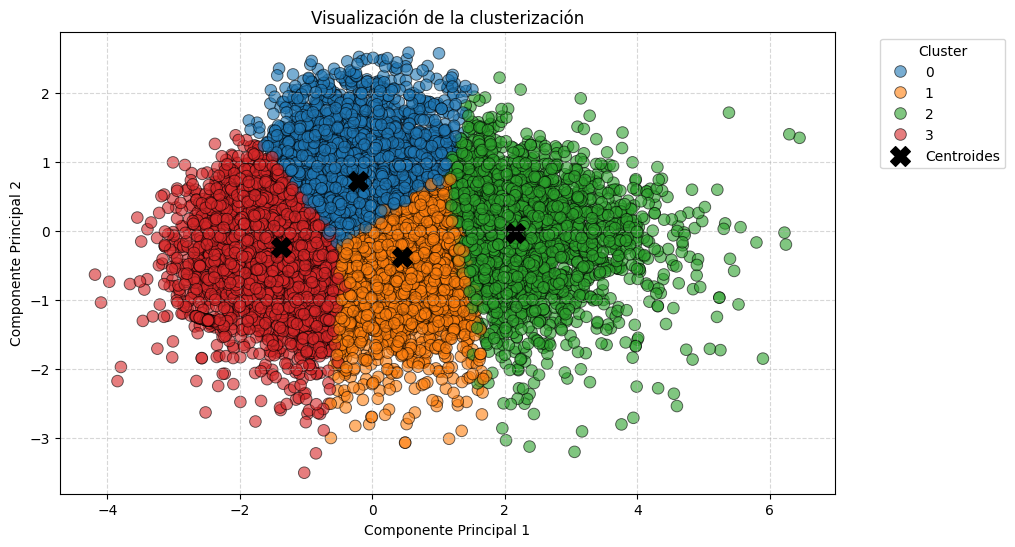

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

# Aplicar PCA con 3 componentes para mejorar la separación de clusters
pca = PCA(n_components=3)
df_cluster_pca = pca.fit_transform(df_cluster_scaled)

# Convertir a DataFrame para facilidad en graficación
df_pca = pd.DataFrame(df_cluster_pca, columns=["PC1", "PC2", "PC3"])
df_pca["cluster"] = df_twitter_exploratory["cluster_kmeans"]

# Calcular centroides de cada cluster
centroids = df_pca.groupby("cluster")[["PC1", "PC2"]].mean()

# Crear scatter plot mejorado
plt.figure(figsize=(10,6))
sns.scatterplot(
    x=df_pca["PC1"],
    y=df_pca["PC2"],
    hue=df_pca["cluster"],
    palette="tab10",
    alpha=0.6,
    edgecolor="black",
    s=70
)

# Añadir centroides al gráfico
plt.scatter(centroids["PC1"], centroids["PC2"], marker="X", s=200, c="black", label="Centroides")

plt.xlabel("Componente Principal 1")
plt.ylabel("Componente Principal 2")
plt.title("Visualización de la clusterización")
plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()

In [ ]:
#Resultados de la clsuterización por cluster.
import pandas as pd

#Dataset
file_path = "clusters_kmeans.csv"
df_clusters = pd.read_csv(file_path)

#Resultados, visualización.
df_clusters.head()

,cluster_kmeans,likeCount,retweetCount,replyCount,viewCount,author/followers
0,0,297.707905,75.219368,36.240119,2.029950e+05,8.825645e+05
1,1,1067.830918,304.763842,56.651431,4.560541e+05,6.260076e+04
2,2,5949.083333,1461.145238,427.030655,3.741446e+06,1.055723e+06
3,3,149.346079,36.957244,16.898193,6.487655e+04,1.849628e+04


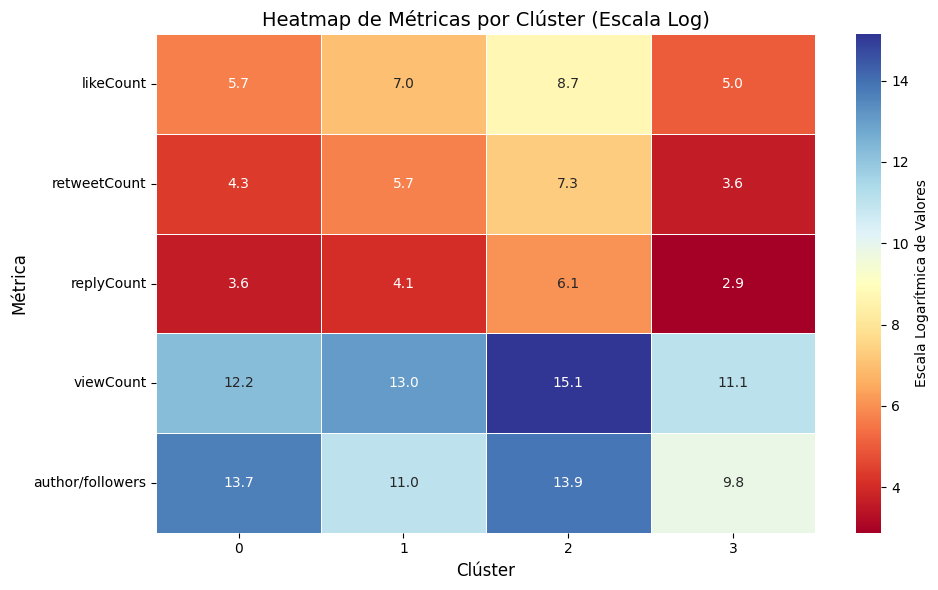

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

df_heatmap = pd.read_csv("clusters_kmeans.csv")

if 'cluster_kmeans' in df_heatmap.columns:
    df_heatmap.set_index('cluster_kmeans', inplace=True)

#Aplicamos log(x + 1) para normalizar escala y evitar log(0)
df_heatmap_log = np.log1p(df_heatmap)

#Heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(
    df_heatmap_log.T,
    cmap="RdYlBu",
    annot=True,
    fmt=".1f",          #Formato numérico
    linewidths=0.5,
    cbar_kws={"label": "Escala Logarítmica de Valores"}
)

plt.title("Heatmap de Métricas por Clúster (Escala Log)", fontsize=14)
plt.xlabel("Clúster", fontsize=12)
plt.ylabel("Métrica", fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

<ipython-input-12-a8c154d859ad>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df_twitter_exploratory["cluster_kmeans"], y=df_twitter_exploratory["likeCount"], palette="Set2")


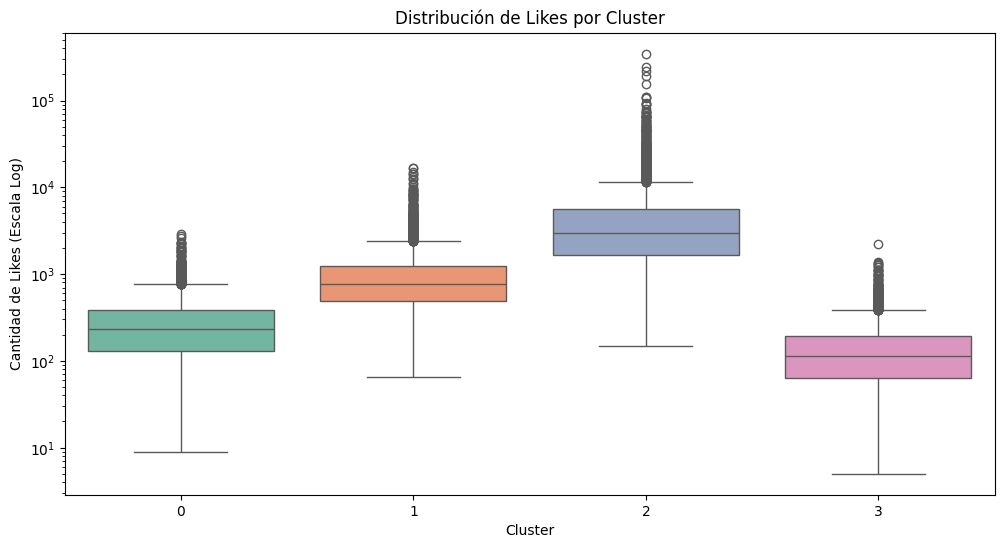

In [ ]:
plt.figure(figsize=(12,6))

# Comparar la distribución de likes en cada cluster
sns.boxplot(x=df_twitter_exploratory["cluster_kmeans"], y=df_twitter_exploratory["likeCount"], palette="Set2")
plt.yscale("log")  # Escala logarítmica para visualizar mejor
plt.xlabel("Cluster")
plt.ylabel("Cantidad de Likes (Escala Log)")
plt.title("Distribución de Likes por Cluster")
plt.show()


1.2 Sentiment Score

In [ ]:
!pip install emoji

In [ ]:
!pip install --quiet seaborn scikit-learn pandas matplotlib
!pip install emoji nltk

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


<Figure size 1200x600 with 0 Axes>

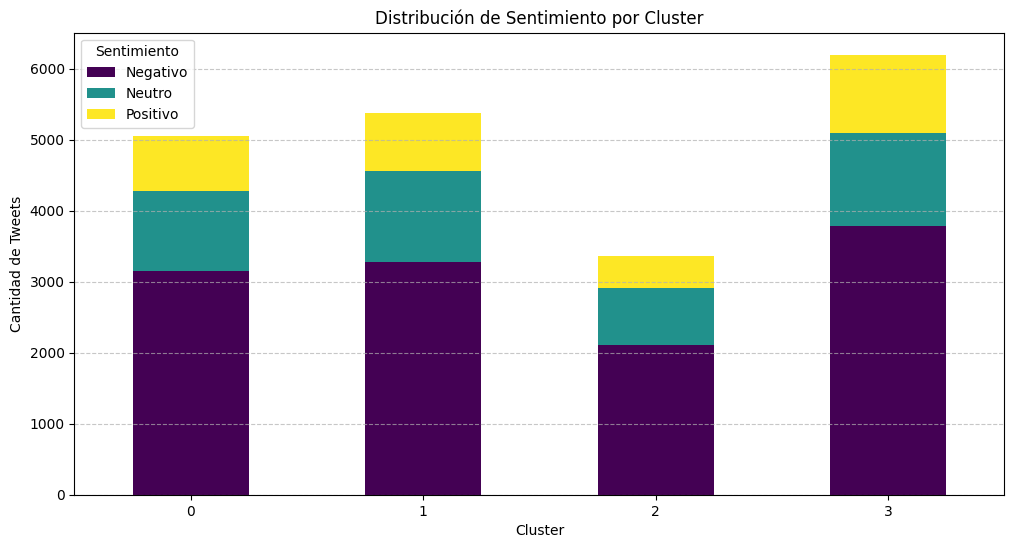

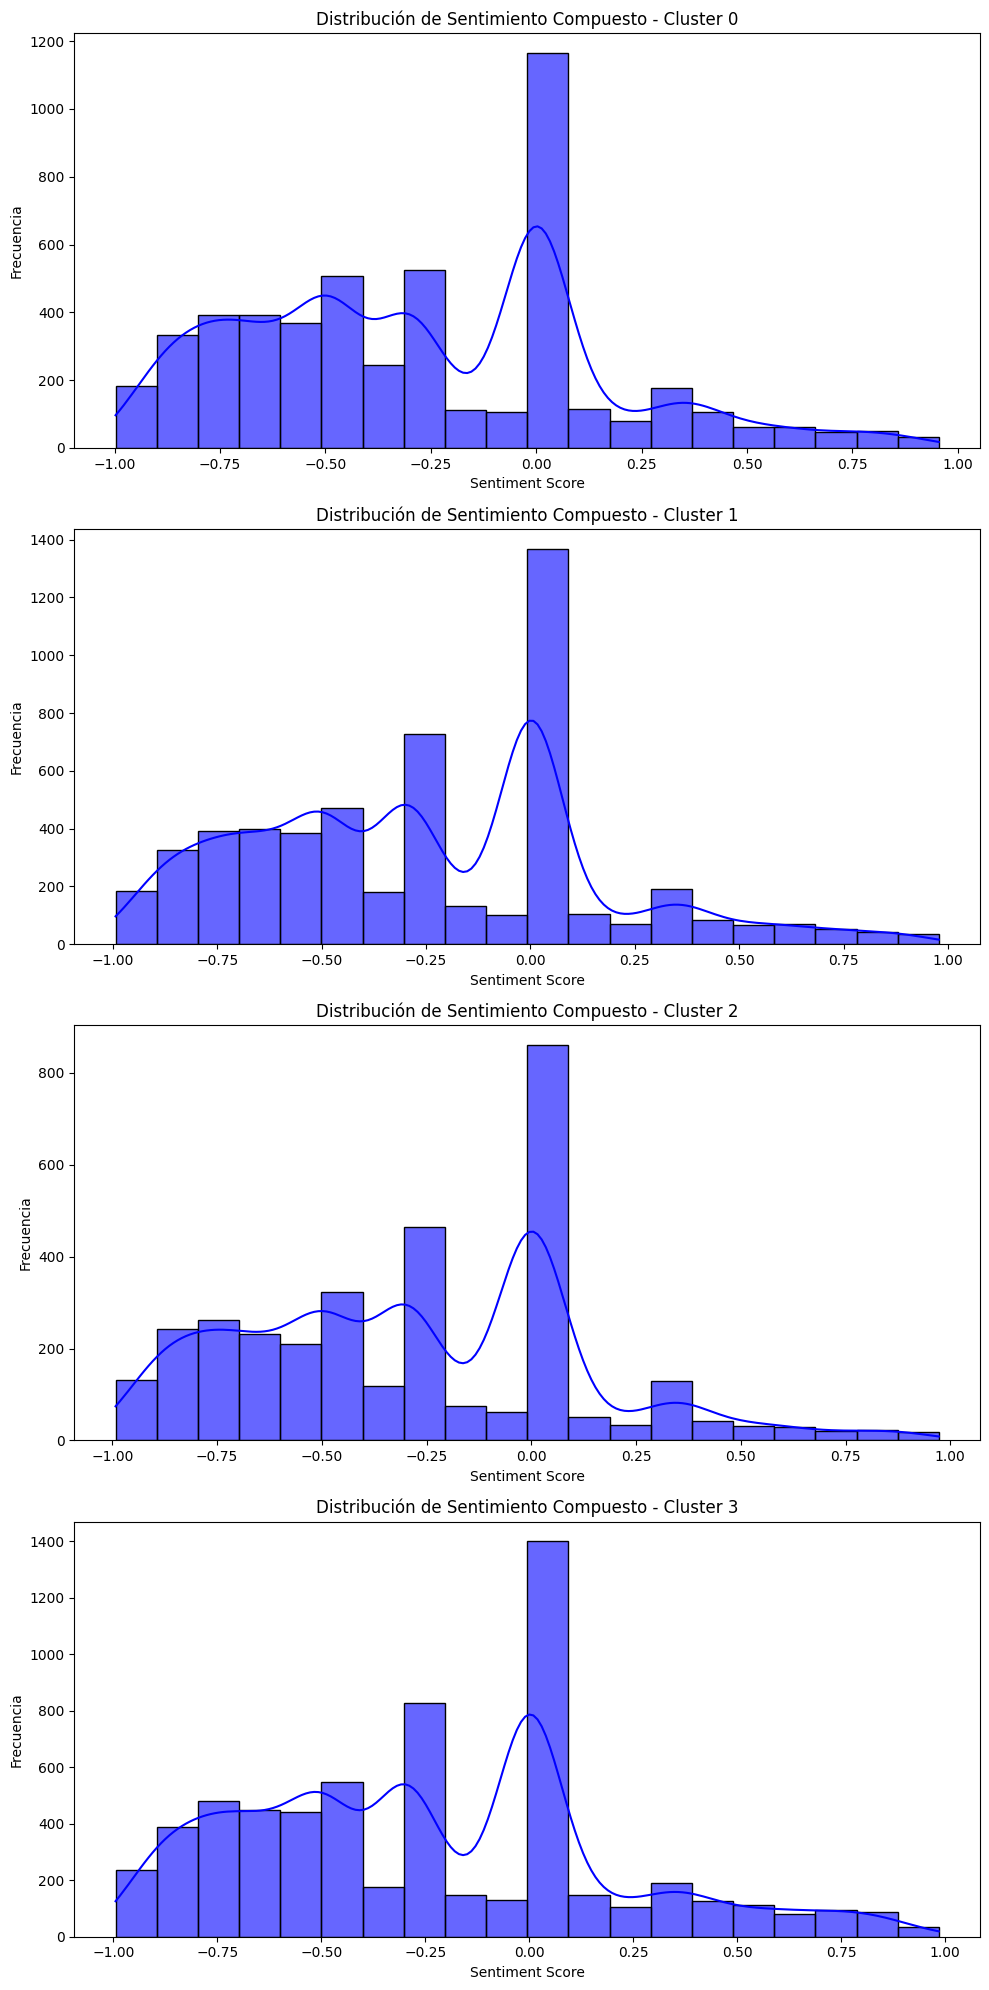

<ipython-input-14-411bad7028cc>:86: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df_sentiment["cluster_kmeans"], y=df_sentiment["sentiment_compound"], palette="viridis")


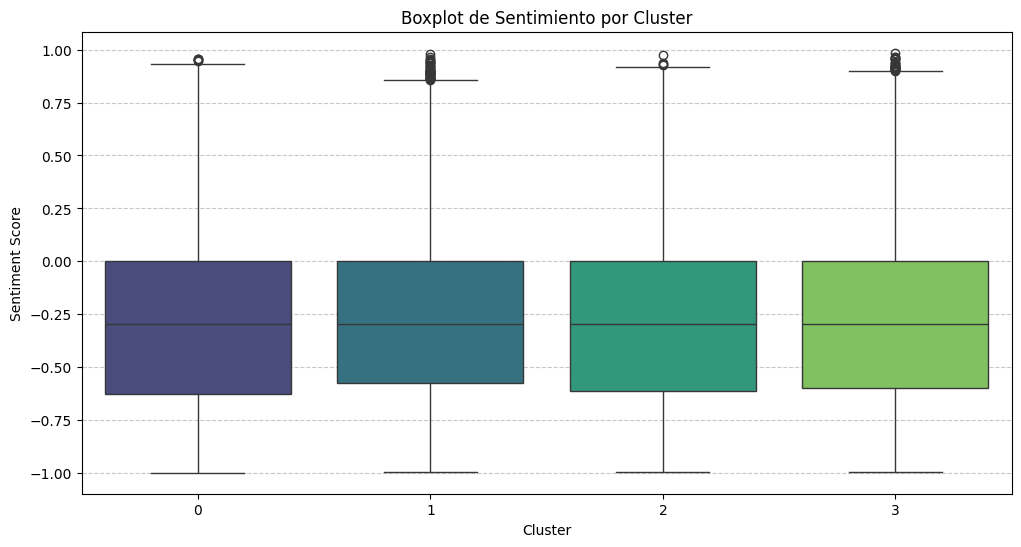

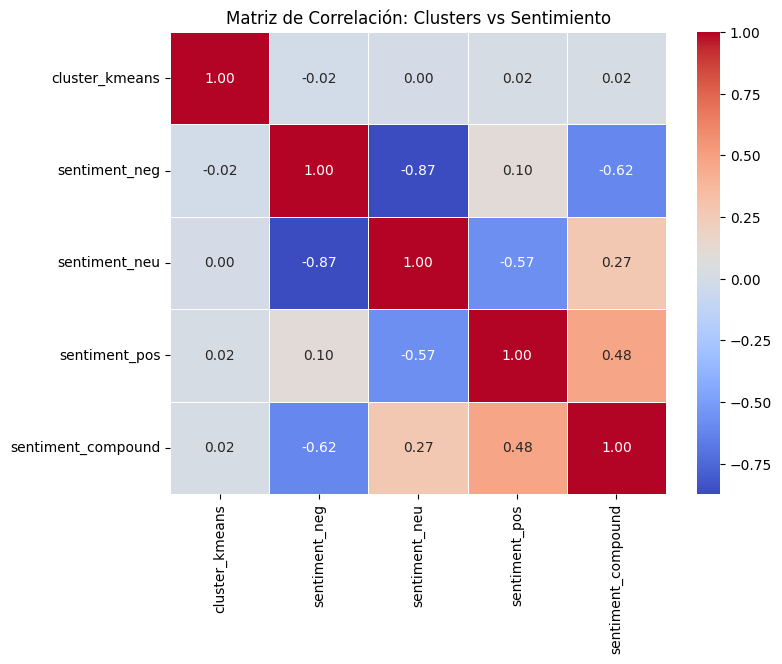

Resumen de Sentimientos por Cluster:


sentiment_category,Negativo,Neutro,Positivo
cluster_kmeans,,,
0,3145,1128,787
1,3280,1282,820
2,2102,810,448
3,3782,1319,1097


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import emoji
from nltk.sentiment import SentimentIntensityAnalyzer
import nltk

#Descargar el analizador de sentimiento VADER
nltk.download("vader_lexicon")

# Cargar el archivo con los tweets y sus clusters
clusters_asignados_path = "clusters_asignados.csv"
df_sentiment = pd.read_csv(clusters_asignados_path, encoding="latin-1", low_memory=False)

# Seleccionar solo las columnas necesarias
df_sentiment = df_sentiment[["fullText", "cluster_kmeans"]].copy()

# Eliminar tweets vacíos
df_sentiment = df_sentiment.dropna()

# Inicializar el analizador de sentimiento de VADER
sia = SentimentIntensityAnalyzer()

# Función avanzada para limpiar el texto
def clean_text(text):
    text = str(text).lower()  # Convertir a minúsculas
    text = re.sub(r"http\S+|www\S+|https\S+", "", text)  # Eliminar URLs
    text = re.sub(r"@\w+|\#", "", text)  # Eliminar menciones y hashtags
    text = re.sub(r"[^\w\s]", "", text)  # Eliminar signos de puntuación
    text = re.sub(r"\s+", " ", text).strip()  # Eliminar espacios en blanco extras
    text = emoji.replace_emoji(text, replace="")  # Eliminar emojis
    return text

df_sentiment["clean_text"] = df_sentiment["fullText"].apply(clean_text)

# Aplicar análisis de sentimiento avanzado
def analyze_sentiment(text):
    scores = sia.polarity_scores(text)
    return pd.Series([scores["neg"], scores["neu"], scores["pos"], scores["compound"]])

df_sentiment[["sentiment_neg", "sentiment_neu", "sentiment_pos", "sentiment_compound"]] = df_sentiment["clean_text"].apply(analyze_sentiment)

# Clasificación del sentimiento en categorías
def categorize_sentiment(score):
    if score > 0.05:
        return "Positivo"
    elif score < -0.05:
        return "Negativo"
    else:
        return "Neutro"

df_sentiment["sentiment_category"] = df_sentiment["sentiment_compound"].apply(categorize_sentiment)

# Resumen estadístico de los scores de sentimiento por cluster
sentiment_summary = df_sentiment.groupby(["cluster_kmeans", "sentiment_category"]).size().unstack().fillna(0)

# Visualización 1: Distribución de sentimiento por cluster (Barras apiladas)
plt.figure(figsize=(12,6))
sentiment_summary.plot(kind="bar", stacked=True, colormap="viridis", figsize=(12,6))
plt.title("Distribución de Sentimiento por Cluster")
plt.xlabel("Cluster")
plt.ylabel("Cantidad de Tweets")
plt.xticks(rotation=0)
plt.legend(title="Sentimiento")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

# Visualización 2: Histogramas de Sentimiento Compuesto por Cluster
num_clusters = len(df_sentiment["cluster_kmeans"].unique())
fig, axes = plt.subplots(num_clusters, 1, figsize=(10, 5 * num_clusters))

for i, cluster in enumerate(sorted(df_sentiment["cluster_kmeans"].unique())):
    cluster_data = df_sentiment[df_sentiment["cluster_kmeans"] == cluster]["sentiment_compound"]
    sns.histplot(cluster_data, bins=20, kde=True, ax=axes[i], color="blue", alpha=0.6)
    axes[i].set_title(f"Distribución de Sentimiento Compuesto - Cluster {cluster}")
    axes[i].set_xlabel("Sentiment Score")
    axes[i].set_ylabel("Frecuencia")

plt.tight_layout()
plt.show()

# Visualización 3: Boxplot de Sentimiento por Cluster
plt.figure(figsize=(12,6))
sns.boxplot(x=df_sentiment["cluster_kmeans"], y=df_sentiment["sentiment_compound"], palette="viridis")
plt.title("Boxplot de Sentimiento por Cluster")
plt.xlabel("Cluster")
plt.ylabel("Sentiment Score")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

# Visualización 4: Matriz de Correlación entre Sentimiento y Clusters
plt.figure(figsize=(8,6))
corr_matrix = df_sentiment[["cluster_kmeans", "sentiment_neg", "sentiment_neu", "sentiment_pos", "sentiment_compound"]].corr()
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Matriz de Correlación: Clusters vs Sentimiento")
plt.show()

# Mostrar el resumen de sentimientos en tabla
print("Resumen de Sentimientos por Cluster:")
display(sentiment_summary)



1.3 Validación Clusterización

In [ ]:
import pandas as pd
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

df_twitter = pd.read_csv("CSV Twitter20kV5.csv", encoding="latin-1", sep=";", low_memory=False)
df_clusters = pd.read_csv("clusters_asignados.csv", encoding="latin-1")

#Fusión
df_merged = df_twitter.merge(df_clusters, on="fullText", how="inner")

features = ["likeCount", "retweetCount", "replyCount", "viewCount", "author/followers"]
df_cluster_scaled = df_merged[features]

#Manejamos de valores NaN
df_cluster_scaled.fillna(df_cluster_scaled.mean(), inplace=True)

#Recuperamos los clusters asignados
cluster_labels = df_merged["cluster_kmeans"]

#Calculamos métricas de validación
db_index = davies_bouldin_score(df_cluster_scaled, cluster_labels)
ch_score = calinski_harabasz_score(df_cluster_scaled, cluster_labels)

print(f"Davies-Bouldin Index: {db_index:.4f} (Valores más bajos indican mejor segmentación)")
print(f"Calinski-Harabasz Score: {ch_score:.4f} (Valores más altos indican mejor segmentación)")

Davies-Bouldin Index: 1.7623 (Valores más bajos indican mejor segmentación)
Calinski-Harabasz Score: 97.0781 (Valores más altos indican mejor segmentación)


<ipython-input-16-3421599e08e2>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cluster_scaled.fillna(df_cluster_scaled.mean(), inplace=True)


1.4 Regresión Lineal Múltiple y Random Forest Regressor

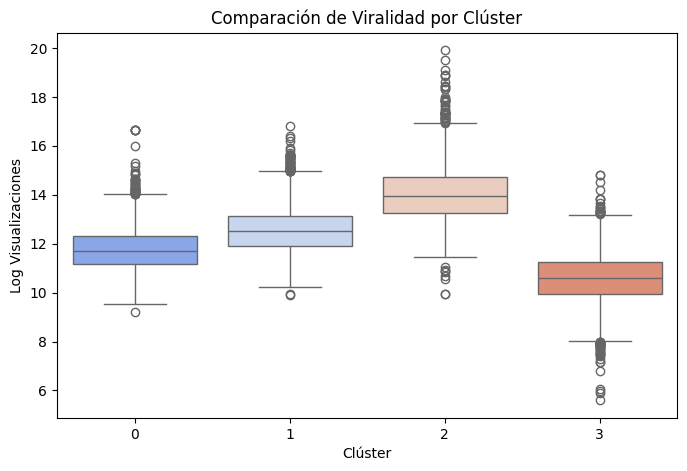

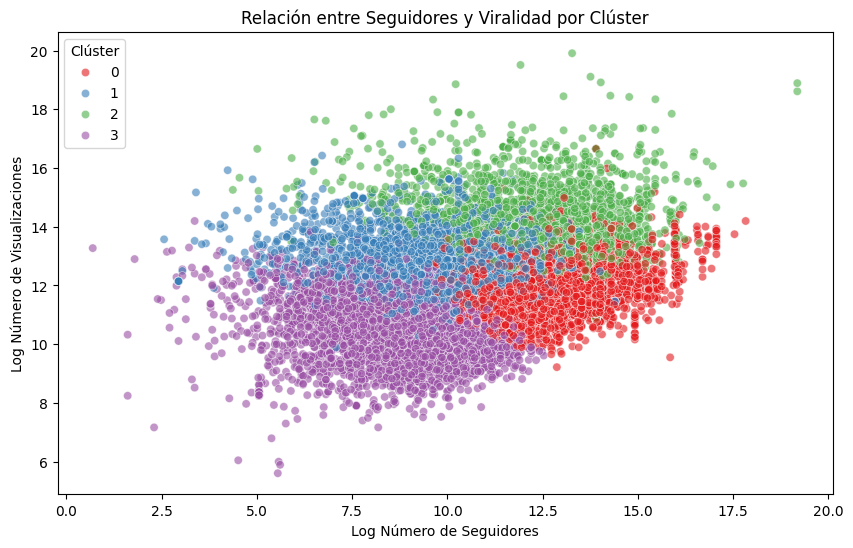


 REGRESIÓN LINEAL PARA CLÚSTER 0
                            OLS Regression Results                            
Dep. Variable:          log_viewCount   R-squared:                       0.243
Model:                            OLS   Adj. R-squared:                  0.242
Method:                 Least Squares   F-statistic:                     313.8
Date:                Mon, 24 Mar 2025   Prob (F-statistic):          1.94e-234
Time:                        17:39:37   Log-Likelihood:                -4463.9
No. Observations:                3917   AIC:                             8938.
Df Residuals:                    3912   BIC:                             8969.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const       

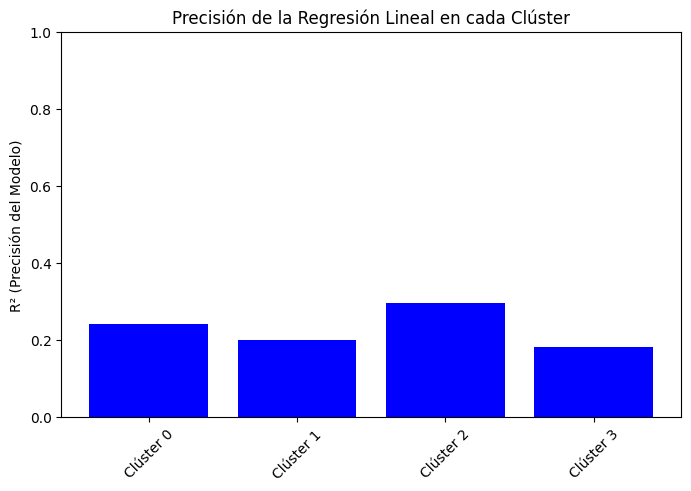

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm
import warnings
warnings.filterwarnings("ignore")

df = pd.read_csv('Dataset_Completo_Integrado.csv', delimiter=',', encoding='ISO-8859-1', on_bad_lines='skip')

variables_relevantes = ["author/followers", "viewCount", "likeCount", "retweetCount", "replyCount", "cluster_kmeans"]
df = df[variables_relevantes]

df.dropna(inplace=True)
df["cluster_kmeans"] = df["cluster_kmeans"].astype(int)

#Transformación logarítmica para corregir la escala
df["log_followers"] = np.log1p(df["author/followers"])
df["log_viewCount"] = np.log1p(df["viewCount"])

#Comparación de viralidad por clúster
plt.figure(figsize=(8,5))
sns.boxplot(x=df["cluster_kmeans"], y=df["log_viewCount"], palette="coolwarm")
plt.xlabel("Clúster")
plt.ylabel("Log Visualizaciones")
plt.title("Comparación de Viralidad por Clúster")
plt.show()

#Relación entre seguidores y viralidad dentro de cada clúster
plt.figure(figsize=(10,6))
sns.scatterplot(x=df["log_followers"], y=df["log_viewCount"], hue=df["cluster_kmeans"], alpha=0.6, palette="Set1")
plt.xlabel("Log Número de Seguidores")
plt.ylabel("Log Número de Visualizaciones")
plt.title("Relación entre Seguidores y Viralidad por Clúster")
plt.legend(title="Clúster")
plt.show()

#REGRESIÓN LINEAL POR CLÚSTER
r2_scores = {}

for cluster in sorted(df["cluster_kmeans"].unique()):
    df_cluster = df[df["cluster_kmeans"] == cluster]

    X = df_cluster[["log_followers", "likeCount", "retweetCount", "replyCount"]]
    y = df_cluster["log_viewCount"]
    X = sm.add_constant(X)  # Agregar constante

    model = sm.OLS(y, X).fit()
    r2_scores[f"Clúster {cluster}"] = model.rsquared

    print(f"\n REGRESIÓN LINEAL PARA CLÚSTER {cluster}")
    print(model.summary())


#Comparación de R2 por clúster
plt.figure(figsize=(8,5))
plt.bar(r2_scores.keys(), r2_scores.values(), color='blue')
plt.ylabel('R² (Precisión del Modelo)')
plt.title('Precisión de la Regresión Lineal en cada Clúster')
plt.ylim(0, 1)
plt.xticks(rotation=45)
plt.show()



Resultados de Random Forest por Clúster:
                MSE        R²
Clúster 0  0.399140  0.427470
Clúster 1  0.538870  0.338804
Clúster 2  0.545076  0.556308
Clúster 3  0.630613  0.377676


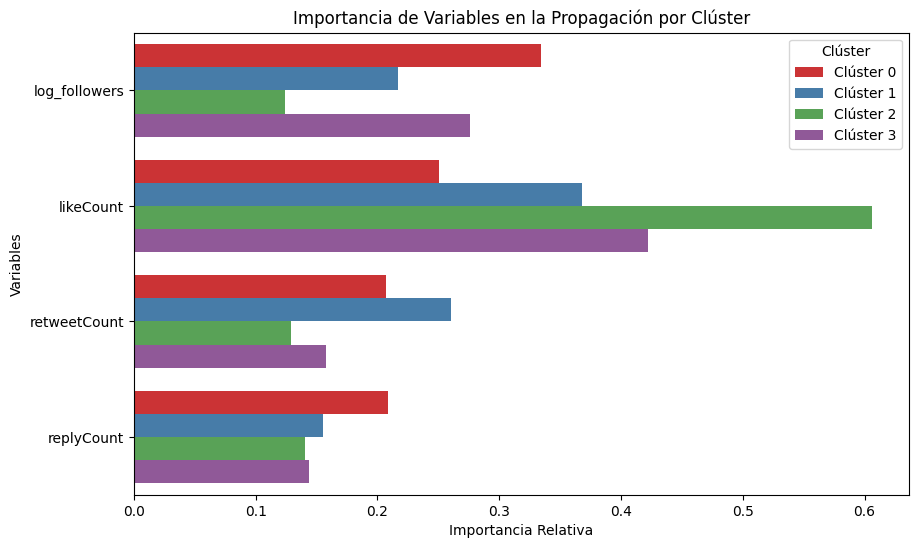

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import warnings

warnings.filterwarnings("ignore")

df = pd.read_csv('Dataset_Completo_Integrado.csv', delimiter=',', encoding='ISO-8859-1', on_bad_lines='skip')

variables_relevantes = ["author/followers", "viewCount", "likeCount", "retweetCount", "replyCount", "cluster_kmeans"]
df = df[variables_relevantes]

df.dropna(inplace=True)
df["cluster_kmeans"] = df["cluster_kmeans"].astype(int)

df["log_followers"] = np.log1p(df["author/followers"])
df["log_viewCount"] = np.log1p(df["viewCount"])

#Entrenamos un Random Forest por Clúster
rf_results = {}
feature_importance_df = pd.DataFrame()

for cluster in sorted(df["cluster_kmeans"].unique()):
    df_cluster = df[df["cluster_kmeans"] == cluster]

    X = df_cluster[["log_followers", "likeCount", "retweetCount", "replyCount"]]
    y = df_cluster["log_viewCount"]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    rf = RandomForestRegressor(n_estimators=100, random_state=42)
    rf.fit(X_train, y_train)
    y_rf_pred = rf.predict(X_test)

    mse_rf = mean_squared_error(y_test, y_rf_pred)
    r2_rf = r2_score(y_test, y_rf_pred)

    #Guardamos métricas del modelo
    rf_results[f"Clúster {cluster}"] = {"MSE": mse_rf, "R²": r2_rf}

    #Guardamos importancia de variables
    importance_df = pd.DataFrame({
        "Variable": X.columns,
        "Importancia": rf.feature_importances_,
        "Clúster": f"Clúster {cluster}"
    })
    feature_importance_df = pd.concat([feature_importance_df, importance_df])

#Resultados
rf_results_df = pd.DataFrame(rf_results).T
print("\nResultados de Random Forest por Clúster:")
print(rf_results_df)

#Visualización
plt.figure(figsize=(10, 6))
sns.barplot(x="Importancia", y="Variable", hue="Clúster", data=feature_importance_df, palette="Set1")
plt.title("Importancia de Variables en la Propagación por Clúster")
plt.xlabel("Importancia Relativa")
plt.ylabel("Variables")
plt.legend(title="Clúster")
plt.show()


**PLANTEAMIENTO 2, para Instagram y TikTok. Análisis de textos**

Test Instagram & TikTok

In [ ]:
#Topic Modeling con LDA para nuestro dataset de INSTAGRAM
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation

df = pd.read_csv("CSV Instagram 10K VF.csv")
#Filtración de textos
df = df[df['text'].notnull()]
df = df[df['text'].str.len() > 50]

#Vectorización avanzada con TF-IDF
vectorizer = TfidfVectorizer(
    max_df=0.90,
    min_df=3,
    stop_words='english',
    ngram_range=(1, 3)  # n-gramas: unigramas, bigramas y trigramas
)
X = vectorizer.fit_transform(df['text'])

#Entrenar modelo LDA
lda = LatentDirichletAllocation(
    n_components=5,         # número de temas
    max_iter=30,
    learning_method='batch',
    random_state=42,
    evaluate_every=-1,
    verbose=1
)
lda.fit(X)

#Resultados
feature_names = vectorizer.get_feature_names_out()
for idx, topic in enumerate(lda.components_):
    print(f"\n Tema {idx + 1}:")
    print(", ".join([feature_names[i] for i in topic.argsort()[:-11:-1]]))


iteration: 1 of max_iter: 30
iteration: 2 of max_iter: 30
iteration: 3 of max_iter: 30
iteration: 4 of max_iter: 30
iteration: 5 of max_iter: 30
iteration: 6 of max_iter: 30
iteration: 7 of max_iter: 30
iteration: 8 of max_iter: 30
iteration: 9 of max_iter: 30
iteration: 10 of max_iter: 30
iteration: 11 of max_iter: 30
iteration: 12 of max_iter: 30
iteration: 13 of max_iter: 30
iteration: 14 of max_iter: 30
iteration: 15 of max_iter: 30
iteration: 16 of max_iter: 30
iteration: 17 of max_iter: 30
iteration: 18 of max_iter: 30
iteration: 19 of max_iter: 30
iteration: 20 of max_iter: 30
iteration: 21 of max_iter: 30
iteration: 22 of max_iter: 30
iteration: 23 of max_iter: 30
iteration: 24 of max_iter: 30
iteration: 25 of max_iter: 30
iteration: 26 of max_iter: 30
iteration: 27 of max_iter: 30
iteration: 28 of max_iter: 30
iteration: 29 of max_iter: 30
iteration: 30 of max_iter: 30

 Tema 1:
la, que, el, en, es, los, https, se, por, una

 Tema 2:
la extrema, la extrema derecha, los bulos l

In [ ]:
#Topic Modeling con LDA AHORA PARA TikTok
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation

df = pd.read_csv("CSV TikTok 1kVF.csv")


#Filtración de nuevo
df = df[df['text'].notnull()]
df = df[df['text'].str.len() > 50]

#Vectorización avanzada con TF-IDF
vectorizer = TfidfVectorizer(
    max_df=0.90,
    min_df=3,
    stop_words='english',
    ngram_range=(1, 3)
)
X = vectorizer.fit_transform(df['text'])

#Entrenamos modelo LDA
lda = LatentDirichletAllocation(
    n_components=5,
    max_iter=30,
    learning_method='batch',
    random_state=42,
    evaluate_every=-1,
    verbose=1
)
lda.fit(X)

#Resultados
feature_names = vectorizer.get_feature_names_out()
for idx, topic in enumerate(lda.components_):
    print(f"\n Tema {idx + 1}:")
    print(", ".join([feature_names[i] for i in topic.argsort()[:-11:-1]]))


iteration: 1 of max_iter: 30
iteration: 2 of max_iter: 30
iteration: 3 of max_iter: 30
iteration: 4 of max_iter: 30
iteration: 5 of max_iter: 30
iteration: 6 of max_iter: 30
iteration: 7 of max_iter: 30
iteration: 8 of max_iter: 30
iteration: 9 of max_iter: 30
iteration: 10 of max_iter: 30
iteration: 11 of max_iter: 30
iteration: 12 of max_iter: 30
iteration: 13 of max_iter: 30
iteration: 14 of max_iter: 30
iteration: 15 of max_iter: 30
iteration: 16 of max_iter: 30
iteration: 17 of max_iter: 30
iteration: 18 of max_iter: 30
iteration: 19 of max_iter: 30
iteration: 20 of max_iter: 30
iteration: 21 of max_iter: 30
iteration: 22 of max_iter: 30
iteration: 23 of max_iter: 30
iteration: 24 of max_iter: 30
iteration: 25 of max_iter: 30
iteration: 26 of max_iter: 30
iteration: 27 of max_iter: 30
iteration: 28 of max_iter: 30
iteration: 29 of max_iter: 30
iteration: 30 of max_iter: 30

 Tema 1:
vallejo, fake news que, news que, golpe, golpe estado, motos, pablo motos, para generar, mexicanos,

In [1]:
print("FIN")

FIN
